In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'cs231n-project/daniel/'

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cs231n-project/daniel


In [ ]:
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import tqdm.notebook as tq
from time import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.style.use('seaborn')
plt.rc('axes', labelsize=17)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float
print(f'device: {device}')

device: cpu


torch.Size([12000, 28, 28]) torch.Size([12000])
torch.Size([100, 1, 28, 28]) torch.Size([100])
tensor(-0.0049)
tensor(1.0034)
tensor(2.0681) tensor(-0.7817)


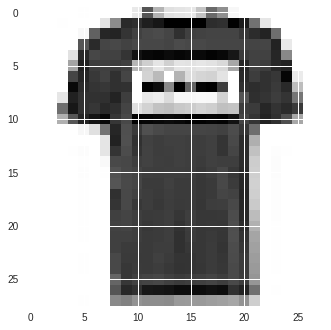

In [ ]:
BATCH_SIZE = 100
NUM_TRAIN = 12000
## Only during dev:
# NUM_TRAIN = 512

def load_Fashion_MNIST():
  transform = T.Compose([T.ToTensor(), T.Normalize(mean=(0.2743), std=(0.3509,))])
  train_dset = datasets.FashionMNIST('./datasets', train=True, download=True, transform=transform)
  test_dset = datasets.FashionMNIST('./datasets', train=False, download=True, transform=transform)
  
  # Get only first two classes
  train_dset.data = train_dset.data[train_dset.targets <= 1]
  train_dset.targets = train_dset.targets[train_dset.targets <= 1]
  test_dset.data = test_dset.data[test_dset.targets <= 1]
  test_dset.targets = test_dset.targets[test_dset.targets <= 1]

  ## Only on dev
  train_dset.data = train_dset.data[:NUM_TRAIN]
  train_dset.targets = train_dset.targets[:NUM_TRAIN]

  return train_dset, test_dset

train_dset, test_dset = load_Fashion_MNIST()
print(train_dset.data.shape, train_dset.targets.shape)

def get_loaders():
  train_loader = DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=False)
  test_loader = DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False)
  return train_loader, test_loader

train_loader, test_loader = get_loaders()

# dataloader batch example
for X, y in train_loader:
  print(X.shape, y.shape)
  print(X.mean())
  print(X.std())
  print(X.max(), X.min())
  plt.imshow(X[0, 0])
  plt.show()
  break

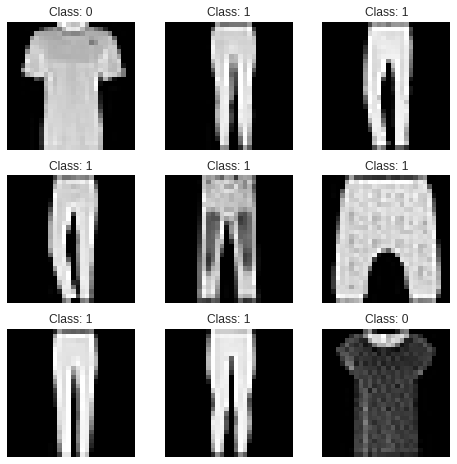

In [ ]:
np.random.seed(0)
def visualize_dataset(dset):
  figure = plt.figure(figsize=(8,8))
  cols, rows = 3, 3
  for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(dset))
    img, label = dset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'Class: {label}')
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
  plt.show()

visualize_dataset(train_dset)

In [ ]:
def check_accuracy(loader, model, loss_fn):  
    num_correct, num_samples = 0, 0
    model.eval()
    loss = 0.0
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            scores = model(X).squeeze()
            loss += loss_fn(scores, y, model, scale_for_SGD=False)
            preds = (scores > 0.5).long()
            num_correct += (preds == y).sum()
            num_samples += preds.shape[0]
    acc = float(num_correct) / num_samples
    return acc, loss, num_correct, num_samples

def print_stats(iteration, loss, accuracy, num_correct, num_samples):
  print('It: %d, loss: %.3f, acc: %.2f%%, ratio: %d/%d' % (iteration, loss, 100 * accuracy, num_correct, num_samples))

def generator():
  n = 0
  while True:
    yield n
    n += 1

def progress_bar(epochs: int):
  return tq.tqdm(generator()) if epochs == -1 else tq.tqdm(range(epochs))

def get_epochs_iter(epochs: int, verbose: bool):
  if not verbose:
    return progress_bar(epochs)
  elif epochs == -1:
    return generator()
  else:
    return range(epochs)
    

def train(model, loss_fn, optimizer, train_loader,
          acc_check_loader, epochs=1, check_every=None, verbose=False):
  '''
  @param epochs:  If epochs = -1, then train will run until accuracy == 1.0.
  '''
  loss_history, loss_timestamps = [], []
  accuracy_history, accuracy_timestamps = [], []
  done = False

  model = model.to(device=device)
  epochs_iter = get_epochs_iter(epochs, verbose)
  start = time()

  for e in epochs_iter:
    if done:
      break
    if verbose: 
      print(f'### Epoch {e} ###')

    for t, (X, y) in enumerate(train_loader):
      model.train()
      X = X.to(device=device, dtype=dtype)
      y = y.to(device=device, dtype=torch.long)

      # Forward pass
      y_pred = model(X)
      loss = loss_fn(y_pred, y, model, scale_for_SGD=True)
      loss_history.append(loss.item())
      loss_timestamps.append(time() - start)

      # Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if check_every is not None and t % check_every == 0:
        accuracy, loss_all, num_correct, num_samples = check_accuracy(acc_check_loader, model, loss_fn)
        accuracy_history.append(accuracy)
        accuracy_timestamps.append(time() - start)
        if verbose:
          print_stats(t, loss_all, accuracy, num_correct, num_samples)
        if accuracy == 1.0:
          done = True
          break

  return loss_history, loss_timestamps, accuracy_history, accuracy_timestamps

# Model Architecture

In [ ]:
H = 34 # same number of neurons as convex
beta = 1e-6

class Polly(nn.Module):
  def forward(self, x):
    return (0.09 * x**2 + 0.5 * x + 0.47)

class Conv2dUnitNorm(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
    super(Conv2dUnitNorm, self).__init__()
    self.Conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)

  def forward(self, x):
    W = self.Conv2d.weight                               # (C_out, 1, F, F)
    C_out = W.shape[0]
    norm = torch.linalg.norm(W.view((C_out, -1)), dim=1) # (C_out, )
    norm = norm.reshape((1, C_out, 1, 1)) # reshape for broadcast
    out = self.Conv2d(x) / norm           # (N, C_out, new_width, new_height)
    return out

# Number of output features width after conv layer: W' = (W + 2P - F) / S + 1
model = nn.Sequential(
    Conv2dUnitNorm(in_channels=1, out_channels=H, kernel_size=3, stride=1, padding=0),
    Polly(),
    nn.AvgPool2d(kernel_size=26, stride=None), # 26 = (28 + 0 - 3) / 1 + 1
    nn.Flatten(),
    nn.Linear(H * 1 * 1, 1, bias=False)
    # nn.Linear(H * 26 * 26, 1, bias=False)
)

def loss_fn(scores, y_labels, model, scale_for_SGD):
  # second_weights = model.state_dict()['3.weight']
  second_weights = model.state_dict()['4.weight']
  if scale_for_SGD:
    # scaled loss for stochastic gradient descent
    loss = 0.5 * ((scores.squeeze() - y_labels)**2).sum() * NUM_TRAIN/y_labels.shape[0] + beta * torch.abs(second_weights).sum()
  else:
    # We are adding the losses over all the dataset, so compute loss as normal
    loss = 0.5 * ((scores.squeeze() - y_labels)**2).sum() + beta * torch.abs(second_weights).sum() * y_labels.shape[0]/NUM_TRAIN
  return loss

optimizer = torch.optim.SGD(model.parameters(), lr=10**(-7), momentum=0.9)
loss_history, loss_timestamps, accuracy_history, accuracy_timestamps = train(model, loss_fn, optimizer, train_loader,
                                       acc_check_loader=train_loader, epochs=5, 
                                       check_every=18, verbose=True)

### Epoch 0 ###
It: 0, loss: 2662.224, acc: 50.00%, ratio: 6000/12000
It: 18, loss: 1461.293, acc: 49.68%, ratio: 5962/12000
It: 36, loss: 771.022, acc: 85.22%, ratio: 10227/12000
It: 54, loss: 638.021, acc: 88.78%, ratio: 10654/12000
It: 72, loss: 586.875, acc: 90.78%, ratio: 10894/12000
It: 90, loss: 523.786, acc: 90.58%, ratio: 10870/12000
It: 108, loss: 470.341, acc: 91.88%, ratio: 11025/12000
### Epoch 1 ###
It: 0, loss: 444.905, acc: 93.40%, ratio: 11208/12000
It: 18, loss: 429.668, acc: 94.79%, ratio: 11375/12000
It: 36, loss: 389.427, acc: 93.92%, ratio: 11271/12000
It: 54, loss: 398.292, acc: 93.34%, ratio: 11201/12000
It: 72, loss: 351.220, acc: 95.96%, ratio: 11515/12000
It: 90, loss: 356.921, acc: 96.62%, ratio: 11594/12000
It: 108, loss: 365.933, acc: 95.31%, ratio: 11437/12000
### Epoch 2 ###
It: 0, loss: 349.055, acc: 96.31%, ratio: 11557/12000
It: 18, loss: 353.855, acc: 96.24%, ratio: 11549/12000
It: 36, loss: 345.244, acc: 96.00%, ratio: 11520/12000
It: 54, loss: 407.

Loss and accuracy


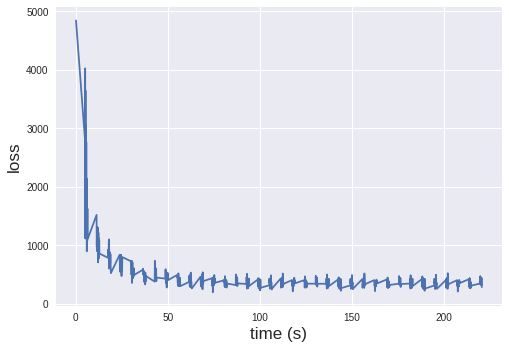

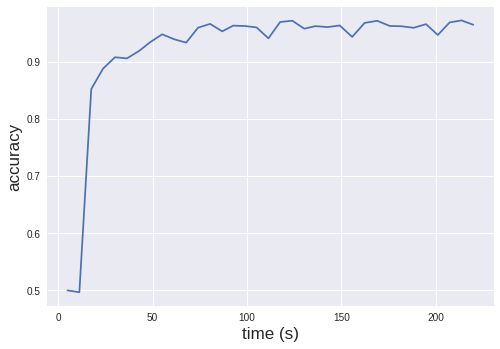

Average Loss and average accuracy


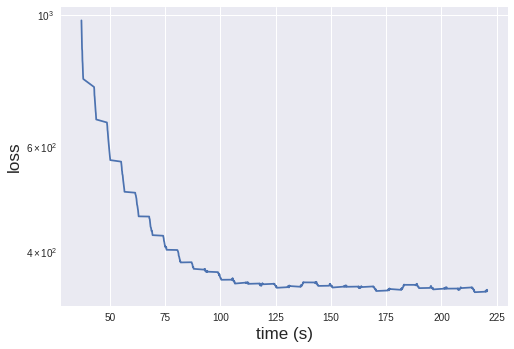

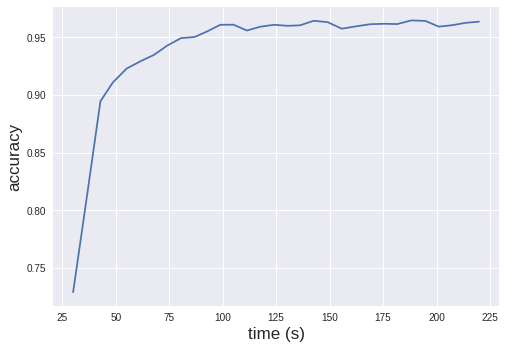

In [ ]:
print('Loss and accuracy')
plt.plot(loss_timestamps, loss_history)
plt.ylabel(r'loss')
plt.xlabel(r'time (s)')
plt.show()
plt.plot(accuracy_timestamps, accuracy_history)
plt.ylabel('accuracy')
plt.xlabel('time (s)')
plt.show()

def moving_average(a: np.array, n: int) :
  '''
  @param a: np.array 1D
  @param n: window size
  '''
  ret = np.cumsum(a, dtype=float)
  ret[n:] = ret[n:] - ret[:-n]
  return ret[n - 1:] / n

print('Average Loss and average accuracy')
window = 100
plt.semilogy(loss_timestamps[window-1:], moving_average(loss_history, window))
plt.ylabel(r'loss')
plt.xlabel(r'time (s)')
plt.show()
window = 5
plt.plot(accuracy_timestamps[window-1:], moving_average(accuracy_history, window))
plt.ylabel('accuracy')
plt.xlabel('time (s)')
plt.show()

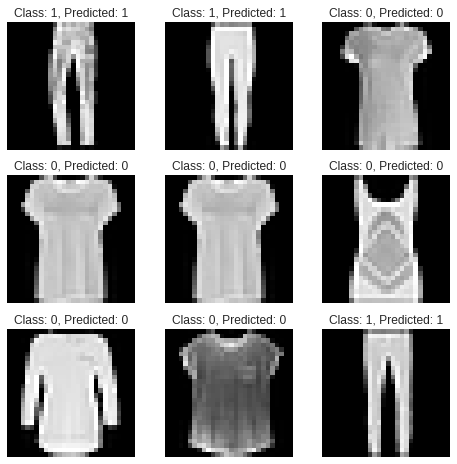

In [ ]:
def visualize_predictions(dset_loader, model):
  X, y = next(iter(dset_loader))
  scores = model(X).squeeze()
  y_preds = torch.zeros(scores.shape, dtype=torch.long)
  y_preds[scores > 0.5] = 1
  # y_preds = scores
  figure = plt.figure(figsize=(8,8))
  cols, rows = 3, 3
  for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(X))
    img, label, pred_label = X[sample_idx], y[sample_idx], y_preds[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'Class: {label}, Predicted: {pred_label}')
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
  plt.show()

visualize_predictions(train_loader, model)